##<font color=cyan>**1. Configuración del Ambiente**


In [11]:
pip install matplotlib


In [12]:
pip install yfinance

In [13]:
# Bibliotecas
import sys
import bs4
from urllib.request import urlopen, urlretrieve, Request
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from bs4 import BeautifulSoup
from IPython.display import clear_output
import time
from datetime import datetime


##<font color=cyan>**2. Obtención de datos**

In [14]:
## Importar base de datos de petróleo crudo

def importar_base_crudo():
  global df_cl
  df_cl= yf.download("CL=F", interval="15m", period="30d")


In [15]:
importar_base_crudo()
df_cl.sort_index(inplace=True, ascending=False)
df_cl.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-11-22 23:45:00,76.269997,76.290001,76.260002,76.269997,76.269997,98
2023-11-22 23:30:00,76.190002,76.290001,76.180000,76.260002,76.260002,300
2023-11-22 23:15:00,76.180000,76.199997,76.160004,76.190002,76.190002,83
2023-11-22 23:00:00,76.209999,76.209999,76.180000,76.190002,76.190002,117
2023-11-22 22:45:00,76.099998,76.220001,76.099998,76.199997,76.199997,276


In [16]:
def extraer_tendencia():
  global precio_actual, tendencia
  ## Importar datos desde https://investing.com/
  url='https://www.investing.com/commodities/crude-oil'
  response = requests.get(url)
  soup = BeautifulSoup(response.content, features='lxml')

  ## Obtener Precio actual

  price=soup.find('div', {'class':['flex flex-wrap gap-x-4 gap-y-2 items-center md:gap-6 mb-3', 'flex flex-wrap gap-x-4 gap-y-2 items-center md:gap-6 mb-3 md:mb-0.5']}).getText()
  precio_actual=float(price.split('+')[0].split('-')[0])

  ## Obtener tendencia
  tendencia = 'subida' if '+' in price else 'bajada'


In [17]:
extraer_tendencia()
print('Precio Crudo (USD/BBL): ', precio_actual)
print('Tendencia: ', tendencia)

Precio Crudo (USD/BBL):  76.44
Tendencia:  subida


##<font color=cyan>**3. Limpieza de datos**

In [18]:
df_cl.shape[0]

2192

In [19]:
# Copia del df
df_cl_limpio = df_cl.copy()

# Filtrar valores unicos en el índice
df_cl_limpio.index = pd.to_datetime(df_cl_limpio.index)
df_cl_limpio = df_cl_limpio[~df_cl_limpio.index.duplicated(keep='first')]
#df_bitcoin_limpio = df_bitcoin_limpio.drop_duplicates(subset=['Datetime'], keep='first')

df_cl_limpio.shape[0]


2192

In [20]:
# Eliminar valores nulos de la columna 'Close'
df_cl_limpio=df_cl_limpio.dropna(subset=['Close'])
df_cl_limpio.shape[0]

2192

In [21]:
# Filtrar valores de 'Volume' superiores a cero
df_cl_limpio = df_cl_limpio[df_cl_limpio['Volume'] > 0]
df_cl_limpio.shape[0]

2191

<Axes: >

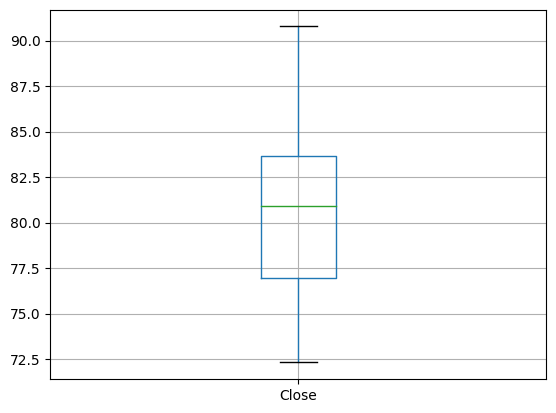

In [22]:
# identificar outliers
df_cl.boxplot(['Close'])

<Axes: >

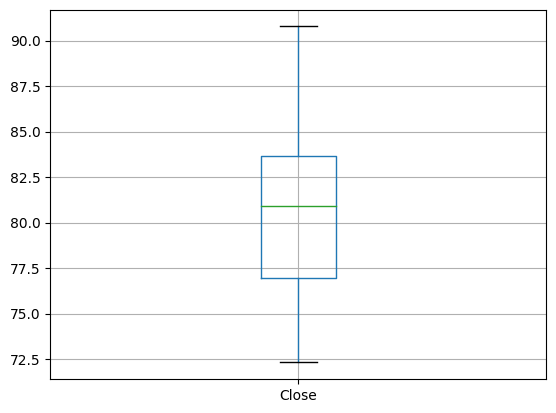

In [23]:
# Remover outliers
cierre= df_cl_limpio['Close']
Q1 = cierre.quantile(0.25)
Q3 = cierre.quantile(0.75)
IIQ = Q3 - Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ
seleccion=(cierre > limite_inferior) & (cierre < limite_superior)
df_cl_limpio = df_cl_limpio[seleccion]
df_cl_limpio.boxplot(['Close'])

In [24]:
# Calcular el valor promedio de los valores de la columna 'Close'
media_crudo = df_cl_limpio['Close'].mean()
media_crudo

80.54265180106361

In [25]:
def limpieza_datos():
    global media_crudo
    # Copia del df
    df_cl_limpio = df_cl.copy()

    # Filtrar valores unicos en el índice
    df_cl_limpio.index = pd.to_datetime(df_cl_limpio.index)
    df_cl_limpio = df_cl_limpio[~df_cl_limpio.index.duplicated(keep='first')]

    # Eliminar valores nulos de la columna 'Close'
    df_cl_limpio=df_cl_limpio.dropna(subset=['Close'])

    # Filtrar valores de 'Volume' superiores a cero
    df_cl_limpio = df_cl_limpio[df_cl_limpio['Volume'] > 0]

    # identificar y remover outliers
    cierre= df_cl_limpio['Close']
    Q1 = cierre.quantile(0.25)
    Q3 = cierre.quantile(0.75)
    IIQ = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IIQ
    limite_superior = Q3 + 1.5 * IIQ
    seleccion=(cierre > limite_inferior) & (cierre < limite_superior)
    df_cl_limpio = df_cl_limpio[seleccion]

    # Calcular el valor promedio de los valores de la columna 'Close'
    media_crudo = df_cl_limpio['Close'].mean()


In [26]:
limpieza_datos()
print('Precio Promedio Crudo (USD/BBL): ', media_crudo)

Precio Promedio Crudo (USD/BBL):  80.54265180106361


##<font color=cyan>**4. Tomar decisiones**

In [27]:
def tomar_decisiones():
  global algoritmo_decision

  algoritmo_decision = ()

  if precio_actual >= media_crudo and tendencia == 'bajada':
        algoritmo_decision = 'Vender'
  elif precio_actual < media_crudo and tendencia == 'subida':
       algoritmo_decision = 'Comprar'
  else:
        algoritmo_decision = 'Esperar'



In [28]:
tomar_decisiones()
print('Decición: ', algoritmo_decision)

Decición:  Comprar


##<font color=cyan>**5. Visualización**

In [96]:
def visualizacion():

  # Adicionar una nueva columna "Promedio"
  df_cl['Promedio'] = media_crudo

  # Configurar el tamaño del gráfico y Título
  fig = plt.figure(figsize=(16, 5))
  sns.set(style='darkgrid')
  plt.title('Crude Robot Trading')

  # Dibujar una línea con los datos del índice y la columna 'Close'
  plt.plot(df_cl.index, df_cl['Close'], label='Precio de Cierre', color='b')

  # Dibujar una línea con los datos del índice y la columna 'Promedio'

  plt.plot(df_cl.index, df_cl['Promedio'], label='Promedio', color='r')

  # Resaltar el último precio de cierre con un marcador circular
  ultimo_valor = df_cl['Close'].iloc[-1]
  plt.scatter(df_cl.index[-1], ultimo_valor, color='b', s=100, zorder=3)
  plt.text(df_cl.index[-1], ultimo_valor+2, f'{ultimo_valor:.2f}', color='black', fontsize=12, ha='left', va='center')
  plt.legend(['Precio de Cierre', 'Promedio'], loc='lower right')

  # Mostrar un mensaje con la decisión del algoritmo en el gráfico

  plt.annotate(f'Decisión: {algoritmo_decision}', xy=(0.90, 0.90), xycoords='axes fraction', ha='center', fontsize=12)

  hora_ejecucion = datetime.now()
  texto_valores = (
     f"Hora de ejecución: {hora_ejecucion}\n"
     f"Precio Promedio Crudo: {media_crudo:.2f}\n"
     f"Precio Actual Crudo: {precio_actual}\n"
     f"Tendencia: {tendencia}"
  )

  eje2=fig.add_axes([0.15,0.15,0.25,0.15])
  eje2.text(0.05, 0.10, texto_valores, ha='left', va='bottom', fontsize=10, color='black')
  eje2.set_xticks([])
  eje2.set_yticks([])

  plt.show()

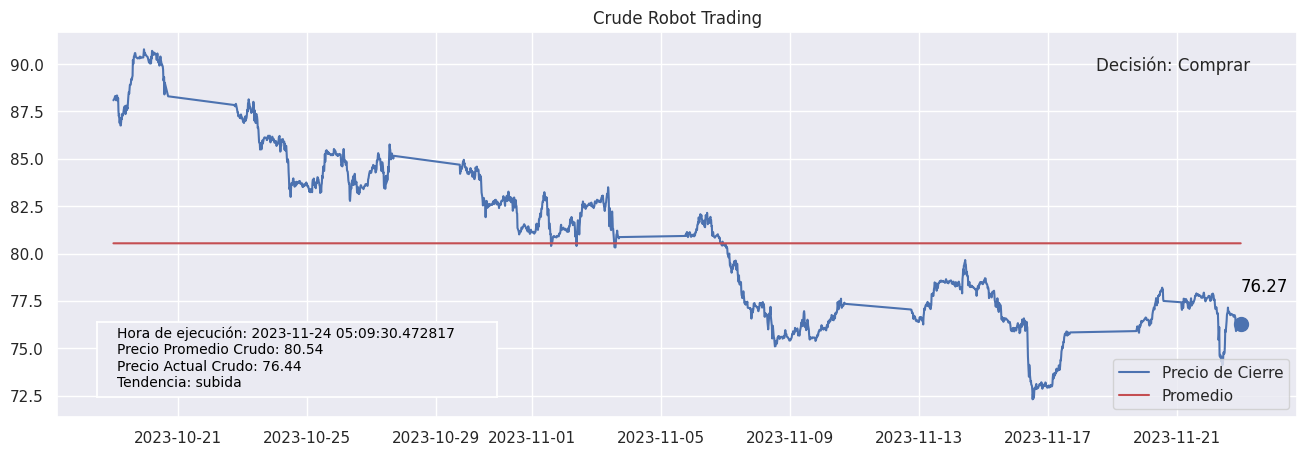

In [97]:
visualizacion()

##<font color=cyan>**6. Automatización**

[*********************100%%**********************]  1 of 1 completed
Hora de ejecución: 2023-11-24 04:06:40.096471
Precio Promedio Crudo:  80.54265180106361
Precio Actual Crudo:  76.44
Tendencia:  subida


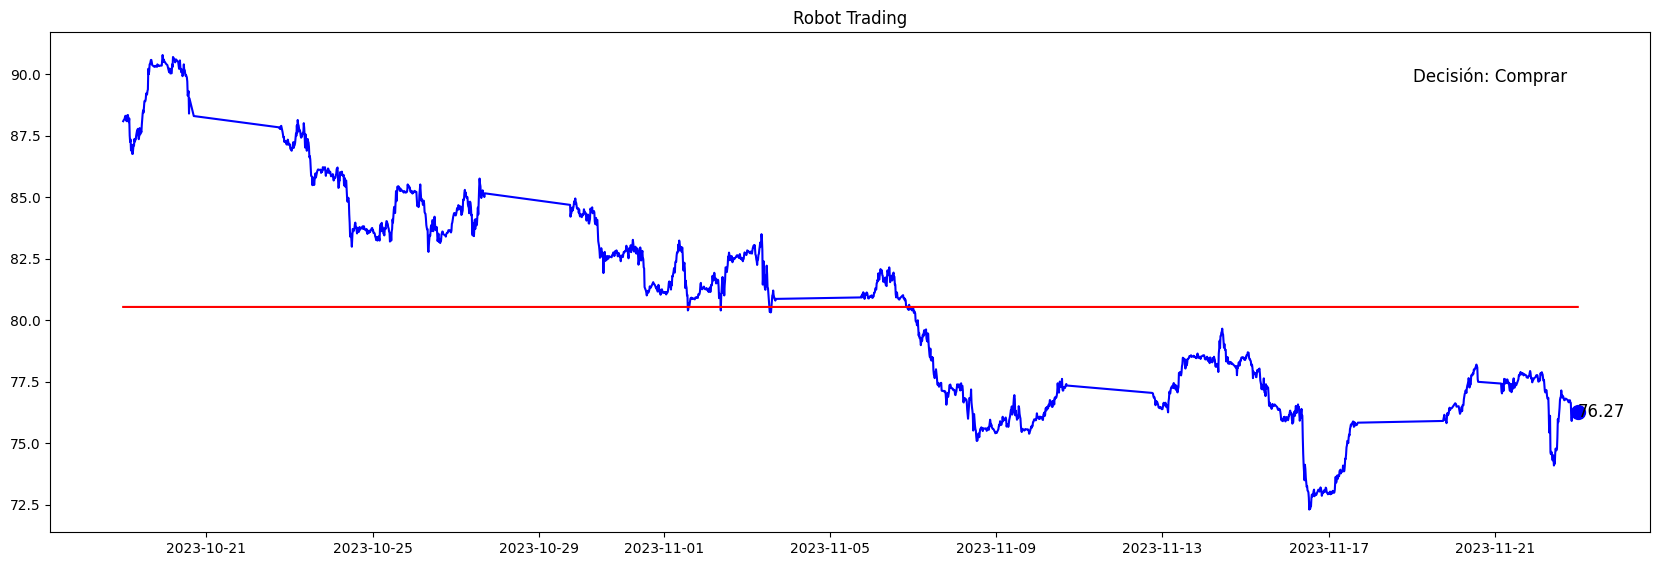

KeyboardInterrupt: ignored

In [31]:
while(True):
  clear_output()
  importar_base_crudo()
  extraer_tendencia()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)